In [203]:
import ee
import numpy as np
import folium
import geopandas as gpd
import json
from util import get_whole_region,shp_to_ee_fmt

try:     
    ee.Initialize()
except:
    ee.Authenticate()
    ee.Initialize()

In [238]:
startDate = '2020-01-01';
endDate = '2021-01-01';
# shp_file = gpd.read_file('/home/graham/Downloads/RFCx_GQ_Shapefiles/Hulu_Batang_Hari_sites_Buffer1k.shp', crs='EPSG:4326')
shp_file = gpd.read_file('/home/graham/Downloads/Bacajai_JP1.shp', crs='EPSG:4326')

# region = get_whole_region(shp_file)

region = ee.Geometry.Polygon(shp_to_ee_fmt(shp_file,0))
dw = ee.ImageCollection('GOOGLE/DYNAMICWORLD/V1').filterDate(startDate, endDate).filterBounds(region);

probabilityBands = [
  'water', 'trees', 'grass', 'flooded_vegetation', 'crops', 'shrub_and_scrub',
  'built', 'bare', 'snow_and_ice'
];

dwTimeSeries = dw.select(probabilityBands)
dwTimeSeries

In [221]:
from geetools import tools
import json

def getDataFromRegion(region):
    dw = ee.ImageCollection('GOOGLE/DYNAMICWORLD/V1').filterDate(startDate, endDate).filterBounds(region);

    probabilityBands = [
    'water', 'trees', 'grass', 'flooded_vegetation', 'crops', 'shrub_and_scrub',
    'built', 'bare', 'snow_and_ice'
    ]

    dwTimeSeries = dw.select(probabilityBands)
    data = tools.imagecollection.getValues(
        collection=dwTimeSeries,
        geometry=region,
        reducer='mode',
        maxPixels=1e7,
        side='client',
        bestEffort=True)
    return data
shp_file = gpd.read_file('/home/graham/Downloads/RFCx_GQ_Shapefiles/Hulu_Batang_Hari_sites_Buffer1k.shp', crs='EPSG:4326')
    
data = []    
s = json.loads(shp_file.to_json())
for i in range(len(s['features'])):
    region = ee.Geometry.Polygon(shp_to_ee_fmt(shp_file,i))
    data.append(getDataFromRegion(region))
    print(len(data))


In [ ]:
x = tools.imagecollection.data2pandas(data)
x = x.reset_index()
x = x.dropna()

In [ ]:
x['index'] = x['index'].apply(lambda x: x.split("_")[0][0:8])

In [ ]:
x['index'] =  pd.to_numeric(x['index'])

ValueError: Unable to parse string "20200607T032541_20200607T034657_T47MQV" at position 0

In [ ]:
x

,index,bare,built,crops,flooded_vegetation,grass,shrub_and_scrub,snow_and_ice,trees,water
3,20200607T032541_20200607T034657_T47MQV,0.037934,0.030610,0.029329,0.031890,0.033725,0.040170,0.031648,0.727905,0.035584
7,20200816T032541_20200816T033204_T47MQV,0.037606,0.030756,0.029542,0.033081,0.033690,0.039552,0.032172,0.728530,0.034425


/home/graham/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/graham/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='index', ylabel='trees'>

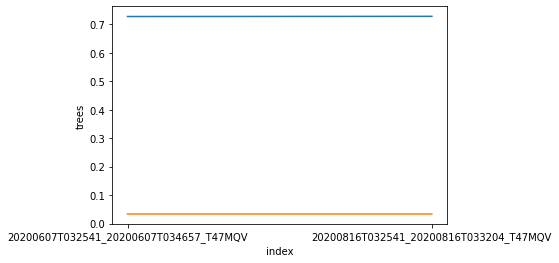

In [ ]:
import seaborn as sns

sns.lineplot(x['index'],x['trees'])
sns.lineplot(x['index'],x['grass'])

In [239]:
reduced = tools.imagecollection.reduceEqualInterval(dwTimeSeries,interval=1,unit='month',reducer='median')


In [240]:
reduced_data = tools.imagecollection.getValues(
    collection=reduced,
    geometry=region,
    reducer='mode',
    maxPixels=1e9,
    side='client',
    bestEffort=True)

In [241]:
reduced_data

{'0': {'bare': 0.03412470619985546,
  'built': 0.03280978226321162,
  'crops': 0.029946812888952314,
  'flooded_vegetation': 0.02684359714630082,
  'grass': 0.033229112484882146,
  'shrub_and_scrub': 0.033253065257914605,
  'snow_and_ice': 0.033108112758552695,
  'trees': 0.7441845137919142,
  'water': 0.030313771492514116},
 '1': {'bare': 0.03613547412915644,
  'built': 0.03075308103095891,
  'crops': 0.02977612223730839,
  'flooded_vegetation': 0.029804911381826976,
  'grass': 0.03340984735579943,
  'shrub_and_scrub': 0.034215622366318844,
  'snow_and_ice': 0.03359290395332405,
  'trees': 0.7363495964830324,
  'water': 0.03296773090413774},
 '2': {'bare': 0.03465470689248013,
  'built': 0.03228326823248077,
  'crops': 0.030773115204618947,
  'flooded_vegetation': 0.026861751969317296,
  'grass': 0.032801672642739574,
  'shrub_and_scrub': 0.03369306956119591,
  'snow_and_ice': 0.033335205822271216,
  'trees': 0.7402981444890022,
  'water': 0.032219118935199874},
 '3': {'bare': 0.03603

In [242]:
x = tools.imagecollection.data2pandas(reduced_data)
x = x.reset_index()

In [243]:
x

,index,bare,built,crops,flooded_vegetation,grass,shrub_and_scrub,snow_and_ice,trees,water
0,0,0.034125,0.032810,0.029947,0.026844,0.033229,0.033253,0.033108,0.744185,0.030314
1,1,0.036135,0.030753,0.029776,0.029805,0.033410,0.034216,0.033593,0.736350,0.032968
2,2,0.034655,0.032283,0.030773,0.026862,0.032802,0.033693,0.033335,0.740298,0.032219
3,3,0.036034,0.032330,0.029503,0.030294,0.032936,0.036993,0.032404,0.740174,0.033176
4,4,0.036066,0.032781,0.029584,0.030286,0.032983,0.036997,0.032773,0.740187,0.033024
5,5,0.036074,0.033177,0.029990,0.029774,0.033264,0.037031,0.032466,0.736315,0.032801
6,6,0.036113,0.033310,0.029916,0.030095,0.033444,0.036881,0.033318,0.736298,0.032546
7,7,0.036115,0.033451,0.030231,0.026417,0.033678,0.037173,0.033462,0.736299,0.029826
8,8,0.038072,0.029507,0.032190,0.029051,0.036765,0.036151,0.034163,0.732393,0.029781


In [245]:
x = x.melt('index',var_name='bands',value_name='values')


In [246]:
x = x.sort_values(by=['index'])
x = x.dropna()

In [244]:
import pandas as pd
x['index'] = pd.to_numeric(x['index'])

In [247]:
x

,index,bands,values
0,0,bare,0.034125
36,0,grass,0.033229
45,0,shrub_and_scrub,0.033253
27,0,flooded_vegetation,0.026844
54,0,snow_and_ice,0.033108
...,...,...,...
17,8,built,0.029507
62,8,snow_and_ice,0.034163
35,8,flooded_vegetation,0.029051
44,8,grass,0.036765


In [ ]:
ee.batch.Task.

<Figure size 2160x3240 with 0 Axes>

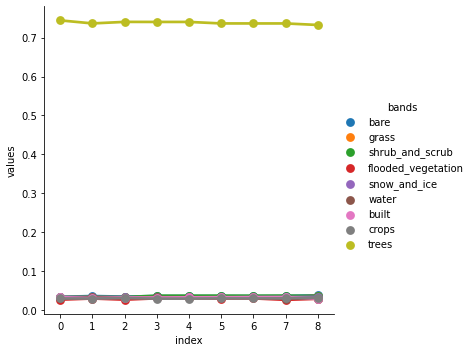

In [248]:
from matplotlib import pyplot as plt
import seaborn as sns

plt.figure(figsize=(30,45))
sns.catplot(x='index',y='values',hue='bands',data=x,kind='point')
